In [71]:
import numpy as np
import mne
import os, glob
import matplotlib.pyplot as plt

mne.viz.set_browser_backend("matplotlib")

'matplotlib'

### Set Parameters

In [72]:
# set parameters
SUBJECT = "C"
SESSION = "Moth5"
BLOCKS = ["01", "02", "03", "04", "05", "06", "07"]
ECG_METHOD = "first"  # "self" or "first" or None
EOG_METHOD = "first"  # "self" or "first" or None
LOC_SSS = f"/project_data/volume0/jerryjin/moth_meg/{SESSION}/mysss/{SUBJECT}/"
LOC_SAVE = f"/project_data/volume0/jerryjin/moth_meg/{SESSION}/mysss_myafter/{SUBJECT}/"
PLOT = True

In [73]:
# make save directory if it doesn't exist
if not os.path.exists(LOC_SAVE):
    os.makedirs(LOC_SAVE)

### Check Files

In [74]:
files = sorted(glob.glob(LOC_SSS + "*.fif"))
files

['/project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_01_sss_raw.fif',
 '/project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_02_sss_raw.fif',
 '/project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_03_sss_raw.fif',
 '/project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_04_sss_raw.fif',
 '/project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_05_sss_raw.fif',
 '/project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_06_sss_raw.fif',
 '/project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_07_sss_raw.fif',
 '/project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_EmptyRoom_sss_raw.fif']

In [75]:
# load first recording
first_f = glob.glob(LOC_SSS + f"*{SUBJECT}_{SESSION}_01*raw.fif")[0]
first_sss = mne.io.read_raw_fif(first_f, preload=True)

Opening raw data file /project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_01_sss_raw.fif...


    Range : 39000 ... 877999 =     39.000 ...   877.999 secs
Ready.
Reading 0 ... 838999  =      0.000 ...   838.999 secs...


### Run Preprocess

In [76]:
# load empty room
er_f = glob.glob(LOC_SSS + f"*{SUBJECT}_{SESSION}_EmptyRoom*raw.fif")[0]
er_sss = mne.io.read_raw_fif(er_f, preload=True)

# determine intervals
n_windows = 4
window_len = 10
er_len = er_sss[0][0].shape[1]
center_dist = np.floor(er_len / (1.0 + n_windows))
curr_center = center_dist
starts = []
stops = []
for i in range(n_windows):
    half_win_len = np.floor(er_sss.info["sfreq"] * window_len * 0.5)
    (win_start, win_stop) = (curr_center - half_win_len, curr_center + half_win_len)
    win_start = er_sss.times[int(win_start)]
    win_stop = er_sss.times[int(win_stop)]
    curr_center += center_dist
    starts.append(win_start)
    stops.append(win_stop)

# calculate emptyroom projs
er_projs = []
for start, stop in zip(starts, stops):
    er_projs.extend(mne.compute_proj_raw(er_sss, start=start, stop=stop, n_grad=2, n_mag=2, verbose=True))

Opening raw data file /project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_EmptyRoom_sss_raw.fif...


    Range : 737000 ... 1108999 =    737.000 ...  1108.999 secs
Ready.
Reading 0 ... 371999  =      0.000 ...   371.999 secs...
Not setting metadata
10 matching events found
No baseline correction applied
Dropped 0/10 epochs
Adding projection: planar-Raw-69.400-79.400-PCA-01 (exp var=23.8%)
Adding projection: planar-Raw-69.400-79.400-PCA-02 (exp var=8.3%)
Adding projection: axial-Raw-69.400-79.400-PCA-01 (exp var=31.3%)
Adding projection: axial-Raw-69.400-79.400-PCA-02 (exp var=13.7%)
No channels 'eeg' found. Skipping.
Not setting metadata
10 matching events found
No baseline correction applied
Dropped 0/10 epochs
Adding projection: planar-Raw-143.800-153.800-PCA-01 (exp var=13.1%)
Adding projection: planar-Raw-143.800-153.800-PCA-02 (exp var=10.1%)
Adding projection: axial-Raw-143.800-153.800-PCA-01 (exp var=20.7%)
Adding projection: axial-Raw-143.800-153.800-PCA-02 (exp var=17.8%)
No channels 'eeg' found. Skipping.
Not setting metadata
10 matching events found
No baseline correction a

In [77]:
# define bandpass filter parameters
bandpass_params = dict(
    l_freq=1.0,
    h_freq=150.0,
    filter_length="10s",
    l_trans_bandwidth=0.5,
    h_trans_bandwidth=0.5,
    phase="zero-double",
    fir_window="hann",
    fir_design="firwin2",
    verbose=True,
)

In [78]:
# define notch filter parameters
notch_params = dict(
    freqs=[60, 120],
    filter_length="10s",
    phase="zero-double",
    fir_window="hann",
    fir_design="firwin2",
    verbose=True,
)

In [79]:
all_raw_sss = []
for BLOCK in BLOCKS:

    # load raw data
    sss_f = glob.glob(LOC_SSS + f"*{SUBJECT}_{SESSION}_{BLOCK}*raw.fif")[0]
    raw_sss = mne.io.read_raw_fif(sss_f, preload=True)

    # empty room correction
    raw_sss.add_proj(er_projs)
    raw_sss.apply_proj()

    # bandpass filtering
    raw_sss.filter(**bandpass_params)

    # notch filtering
    raw_sss.notch_filter(**notch_params)

    # heartbeat removal
    if ECG_METHOD is not None:
        if ECG_METHOD == "first":
            # do all the steps for first recording
            first_sss_sub = first_sss.copy()
            first_sss_sub.add_proj(er_projs)
            first_sss_sub.apply_proj()
            first_sss_sub.filter(**bandpass_params)
            first_sss_sub.notch_filter(**notch_params)
            # compute ecg projs
            ecg_projs, _ = mne.preprocessing.compute_proj_ecg(first_sss_sub, average=False)
            del first_sss_sub
        elif ECG_METHOD == "self":
            ecg_projs, _ = mne.preprocessing.compute_proj_ecg(raw_sss, average=False)
        else:
            raise ValueError("ECG_METHOD not recognized.")
        raw_sss.add_proj(ecg_projs)
        raw_sss.apply_proj()

    # eyeblink removal
    if EOG_METHOD is not None:
        if EOG_METHOD == "first":
            # do all the steps for first recording
            first_sss_sub = first_sss.copy()
            first_sss_sub.add_proj(er_projs)
            first_sss_sub.apply_proj()
            first_sss_sub.filter(**bandpass_params)
            first_sss_sub.notch_filter(**notch_params)
            ecg_projs, _ = mne.preprocessing.compute_proj_ecg(first_sss_sub, average=False)
            first_sss_sub.add_proj(ecg_projs)
            first_sss_sub.apply_proj()
            # compute eog projs
            eog_projs, _ = mne.preprocessing.compute_proj_eog(first_sss_sub, average=False)
            del first_sss_sub
        elif EOG_METHOD == "self":
            eog_projs, _ = mne.preprocessing.compute_proj_eog(raw_sss, average=False)
        else:
            raise ValueError("EOG_METHOD not recognized.")
        raw_sss.add_proj(eog_projs)
        raw_sss.apply_proj()

    # save
    save_f = os.path.basename(sss_f).replace("_raw.fif", "_er-4-10-2-2_band-1-150_notch-60-120_ecg-first_eog-first_raw.fif")
    raw_sss.save(LOC_SAVE + save_f)

    # append to list for plotting
    all_raw_sss.append(raw_sss)

Opening raw data file /project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_01_sss_raw.fif...


    Range : 39000 ... 877999 =     39.000 ...   877.999 secs
Ready.
Reading 0 ... 838999  =      0.000 ...   838.999 secs...
16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 150.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.9s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.7s


16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 150.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.9s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.7s


Including 16 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG003 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 851 (average pulse 60.85816448152563 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.8s


Not setting metadata
851 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 16)
16 projection items activated
Using data from preloaded Raw for 851 events and 601 original time points ...
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG2221']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'M

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.7s


Adding projection: planar-999--0.200-0.400-PCA-01 (exp var=25.5%)
Adding projection: planar-999--0.200-0.400-PCA-02 (exp var=12.6%)
Adding projection: axial-999--0.200-0.400-PCA-01 (exp var=32.9%)
Adding projection: axial-999--0.200-0.400-PCA-02 (exp var=17.3%)
No channels 'eeg' found. Skipping.
Done.
20 projection items deactivated
Created an SSP operator (subspace dimension = 20)
20 projection items activated
SSP projectors applied...
16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 150.00 Hz
- U

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.8s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.6s


Including 16 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG003 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 851 (average pulse 60.85816448152563 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.7s


Not setting metadata
851 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 16)
16 projection items activated
Using data from preloaded Raw for 851 events and 601 original time points ...
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG2221']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'M

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.7s


Adding projection: planar-999--0.200-0.400-PCA-01 (exp var=25.5%)
Adding projection: planar-999--0.200-0.400-PCA-02 (exp var=12.6%)
Adding projection: axial-999--0.200-0.400-PCA-01 (exp var=32.9%)
Adding projection: axial-999--0.200-0.400-PCA-02 (exp var=17.3%)
No channels 'eeg' found. Skipping.
Done.
20 projection items deactivated
Created an SSP operator (subspace dimension = 20)
20 projection items activated
SSP projectors applied...
Including 20 SSP projectors from raw file
Running EOG SSP computation
Using EOG channels: EOG001, EOG002
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG002 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.8s


Not setting metadata
124 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 20)
20 projection items activated
Using data from preloaded Raw for 124 events and 401 original time points ...
0 bad epochs dropped
Adding projection: planar-998--0.200-0.200-PCA-01 (exp var=13.0%)
Adding projection: planar-998--0.200-0.200-PCA-02 (exp var=11.9%)
Adding projection: axial-998--0.200-0.200-PCA-01 (exp var=19.5%)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Adding projection: axial-998--0.200-0.200-PCA-02 (exp var=15.5%)
No channels 'eeg' found. Skipping.
Done.
24 projection items deactivated
Created an SSP operator (subspace dimension = 24)
24 projection items activated
SSP projectors applied...
Writing /project_data/volume0/jerryjin/moth_meg/Moth5/mysss_myafter/C/C_Moth5_01_sss_er-4-10-2-2_band-1-150_notch-60-120_ecg-first_eog-first_raw.fif
Closing /project_data/volume0/jerryjin/moth_meg/Moth5/mysss_myafter/C/C_Moth5_01_sss_er-4-10-2-2_band-1-150_notch-60-120_ecg-first_eog-first_raw.fif
[done]
Opening raw data file /project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_02_sss_raw.fif...
    Range : 70000 ... 969999 =     70.000 ...   969.999 secs
Ready.
Reading 0 ... 899999  =      0.000 ...   899.999 secs...
16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   15.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   15.1s


16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 150.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.7s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.7s


Including 16 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG003 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 851 (average pulse 60.85816448152563 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.8s


Not setting metadata
851 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 16)
16 projection items activated
Using data from preloaded Raw for 851 events and 601 original time points ...
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG2221']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'M

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.7s


Adding projection: planar-999--0.200-0.400-PCA-01 (exp var=25.5%)
Adding projection: planar-999--0.200-0.400-PCA-02 (exp var=12.6%)
Adding projection: axial-999--0.200-0.400-PCA-01 (exp var=32.9%)
Adding projection: axial-999--0.200-0.400-PCA-02 (exp var=17.3%)
No channels 'eeg' found. Skipping.
Done.
20 projection items deactivated
Created an SSP operator (subspace dimension = 20)
20 projection items activated
SSP projectors applied...
16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 150.00 Hz
- U

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.6s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.7s


Including 16 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG003 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 851 (average pulse 60.85816448152563 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.6s


Not setting metadata
851 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 16)
16 projection items activated
Using data from preloaded Raw for 851 events and 601 original time points ...
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG2221']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'M

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.7s


Adding projection: planar-999--0.200-0.400-PCA-01 (exp var=25.5%)
Adding projection: planar-999--0.200-0.400-PCA-02 (exp var=12.6%)
Adding projection: axial-999--0.200-0.400-PCA-01 (exp var=32.9%)
Adding projection: axial-999--0.200-0.400-PCA-02 (exp var=17.3%)
No channels 'eeg' found. Skipping.
Done.
20 projection items deactivated
Created an SSP operator (subspace dimension = 20)
20 projection items activated
SSP projectors applied...
Including 20 SSP projectors from raw file
Running EOG SSP computation
Using EOG channels: EOG001, EOG002
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG002 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.8s


Not setting metadata
124 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 20)
20 projection items activated
Using data from preloaded Raw for 124 events and 401 original time points ...
0 bad epochs dropped
Adding projection: planar-998--0.200-0.200-PCA-01 (exp var=13.0%)
Adding projection: planar-998--0.200-0.200-PCA-02 (exp var=11.9%)
Adding projection: axial-998--0.200-0.200-PCA-01 (exp var=19.5%)
Adding projection: axial-998--0.200-0.200-PCA-02 (exp var=15.5%)
No channels 'eeg' found. Skipping.
Done.
24 projection items deactivated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Created an SSP operator (subspace dimension = 24)
24 projection items activated
SSP projectors applied...
Writing /project_data/volume0/jerryjin/moth_meg/Moth5/mysss_myafter/C/C_Moth5_02_sss_er-4-10-2-2_band-1-150_notch-60-120_ecg-first_eog-first_raw.fif
Closing /project_data/volume0/jerryjin/moth_meg/Moth5/mysss_myafter/C/C_Moth5_02_sss_er-4-10-2-2_band-1-150_notch-60-120_ecg-first_eog-first_raw.fif
[done]
Opening raw data file /project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_03_sss_raw.fif...
    Range : 71000 ... 861999 =     71.000 ...   861.999 secs
Ready.
Reading 0 ... 790999  =      0.000 ...   790.999 secs...
16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Wind

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.7s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.6s


16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 150.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.8s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.7s


Including 16 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG003 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 851 (average pulse 60.85816448152563 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.7s


Not setting metadata
851 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 16)
16 projection items activated
Using data from preloaded Raw for 851 events and 601 original time points ...
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG2221']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'M

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.7s


Adding projection: planar-999--0.200-0.400-PCA-01 (exp var=25.5%)
Adding projection: planar-999--0.200-0.400-PCA-02 (exp var=12.6%)
Adding projection: axial-999--0.200-0.400-PCA-01 (exp var=32.9%)
Adding projection: axial-999--0.200-0.400-PCA-02 (exp var=17.3%)
No channels 'eeg' found. Skipping.
Done.
20 projection items deactivated
Created an SSP operator (subspace dimension = 20)
20 projection items activated
SSP projectors applied...
16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 150.00 Hz
- U

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.8s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.7s


Including 16 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG003 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 851 (average pulse 60.85816448152563 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.8s


Not setting metadata
851 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 16)
16 projection items activated
Using data from preloaded Raw for 851 events and 601 original time points ...
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG2221']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'M

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.7s


Adding projection: planar-999--0.200-0.400-PCA-01 (exp var=25.5%)
Adding projection: planar-999--0.200-0.400-PCA-02 (exp var=12.6%)
Adding projection: axial-999--0.200-0.400-PCA-01 (exp var=32.9%)
Adding projection: axial-999--0.200-0.400-PCA-02 (exp var=17.3%)
No channels 'eeg' found. Skipping.
Done.
20 projection items deactivated
Created an SSP operator (subspace dimension = 20)
20 projection items activated
SSP projectors applied...
Including 20 SSP projectors from raw file
Running EOG SSP computation
Using EOG channels: EOG001, EOG002
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG002 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.8s


Not setting metadata
124 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 20)
20 projection items activated
Using data from preloaded Raw for 124 events and 401 original time points ...
0 bad epochs dropped
Adding projection: planar-998--0.200-0.200-PCA-01 (exp var=13.0%)
Adding projection: planar-998--0.200-0.200-PCA-02 (exp var=11.9%)
Adding projection: axial-998--0.200-0.200-PCA-01 (exp var=19.5%)
Adding projection: axial-998--0.200-0.200-PCA-02 (exp var=15.5%)
No channels 'eeg' found. Skipping.
Done.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


24 projection items deactivated
Created an SSP operator (subspace dimension = 24)
24 projection items activated
SSP projectors applied...
Writing /project_data/volume0/jerryjin/moth_meg/Moth5/mysss_myafter/C/C_Moth5_03_sss_er-4-10-2-2_band-1-150_notch-60-120_ecg-first_eog-first_raw.fif
Closing /project_data/volume0/jerryjin/moth_meg/Moth5/mysss_myafter/C/C_Moth5_03_sss_er-4-10-2-2_band-1-150_notch-60-120_ecg-first_eog-first_raw.fif
[done]
Opening raw data file /project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_04_sss_raw.fif...
    Range : 21000 ... 630999 =     21.000 ...   630.999 secs
Ready.
Reading 0 ... 609999  =      0.000 ...   609.999 secs...
16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, no

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   10.7s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   10.7s


16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 150.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.7s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.6s


Including 16 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG003 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 851 (average pulse 60.85816448152563 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.7s


Not setting metadata
851 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 16)
16 projection items activated
Using data from preloaded Raw for 851 events and 601 original time points ...
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG2221']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'M

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.7s


Adding projection: planar-999--0.200-0.400-PCA-01 (exp var=25.5%)
Adding projection: planar-999--0.200-0.400-PCA-02 (exp var=12.6%)
Adding projection: axial-999--0.200-0.400-PCA-01 (exp var=32.9%)
Adding projection: axial-999--0.200-0.400-PCA-02 (exp var=17.3%)
No channels 'eeg' found. Skipping.
Done.
20 projection items deactivated
Created an SSP operator (subspace dimension = 20)
20 projection items activated
SSP projectors applied...
16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 150.00 Hz
- U

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.6s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.6s


Including 16 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG003 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 851 (average pulse 60.85816448152563 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.6s


Not setting metadata
851 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 16)
16 projection items activated
Using data from preloaded Raw for 851 events and 601 original time points ...
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG2221']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'M

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.7s


Adding projection: planar-999--0.200-0.400-PCA-01 (exp var=25.5%)
Adding projection: planar-999--0.200-0.400-PCA-02 (exp var=12.6%)
Adding projection: axial-999--0.200-0.400-PCA-01 (exp var=32.9%)
Adding projection: axial-999--0.200-0.400-PCA-02 (exp var=17.3%)
No channels 'eeg' found. Skipping.
Done.
20 projection items deactivated
Created an SSP operator (subspace dimension = 20)
20 projection items activated
SSP projectors applied...
Including 20 SSP projectors from raw file
Running EOG SSP computation
Using EOG channels: EOG001, EOG002
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG002 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.9s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   14.1s


Not setting metadata
124 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 20)
20 projection items activated
Using data from preloaded Raw for 124 events and 401 original time points ...
0 bad epochs dropped
Adding projection: planar-998--0.200-0.200-PCA-01 (exp var=13.0%)
Adding projection: planar-998--0.200-0.200-PCA-02 (exp var=11.9%)
Adding projection: axial-998--0.200-0.200-PCA-01 (exp var=19.5%)
Adding projection: axial-998--0.200-0.200-PCA-02 (exp var=15.5%)
No channels 'eeg' found. Skipping.
Done.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


24 projection items deactivated
Created an SSP operator (subspace dimension = 24)
24 projection items activated
SSP projectors applied...
Writing /project_data/volume0/jerryjin/moth_meg/Moth5/mysss_myafter/C/C_Moth5_04_sss_er-4-10-2-2_band-1-150_notch-60-120_ecg-first_eog-first_raw.fif
Closing /project_data/volume0/jerryjin/moth_meg/Moth5/mysss_myafter/C/C_Moth5_04_sss_er-4-10-2-2_band-1-150_notch-60-120_ecg-first_eog-first_raw.fif
[done]
Opening raw data file /project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_05_sss_raw.fif...
    Range : 322000 ... 1064999 =    322.000 ...  1064.999 secs
Ready.
Reading 0 ... 742999  =      0.000 ...   742.999 secs...
16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   12.5s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   12.5s


16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 150.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.9s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.9s


Including 16 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG003 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 851 (average pulse 60.85816448152563 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.9s


Not setting metadata
851 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 16)
16 projection items activated
Using data from preloaded Raw for 851 events and 601 original time points ...
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG2221']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'M

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.7s


Adding projection: planar-999--0.200-0.400-PCA-01 (exp var=25.5%)
Adding projection: planar-999--0.200-0.400-PCA-02 (exp var=12.6%)
Adding projection: axial-999--0.200-0.400-PCA-01 (exp var=32.9%)
Adding projection: axial-999--0.200-0.400-PCA-02 (exp var=17.3%)
No channels 'eeg' found. Skipping.
Done.
20 projection items deactivated
Created an SSP operator (subspace dimension = 20)
20 projection items activated
SSP projectors applied...
16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 150.00 Hz
- U

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.9s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.9s


Including 16 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG003 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 851 (average pulse 60.85816448152563 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.9s


Not setting metadata
851 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 16)
16 projection items activated
Using data from preloaded Raw for 851 events and 601 original time points ...
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG2221']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'M

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    1.0s


Adding projection: planar-999--0.200-0.400-PCA-01 (exp var=25.5%)
Adding projection: planar-999--0.200-0.400-PCA-02 (exp var=12.6%)
Adding projection: axial-999--0.200-0.400-PCA-01 (exp var=32.9%)
Adding projection: axial-999--0.200-0.400-PCA-02 (exp var=17.3%)
No channels 'eeg' found. Skipping.
Done.
20 projection items deactivated
Created an SSP operator (subspace dimension = 20)
20 projection items activated
SSP projectors applied...
Including 20 SSP projectors from raw file
Running EOG SSP computation
Using EOG channels: EOG001, EOG002
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG002 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    8.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   14.4s


Not setting metadata
124 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 20)
20 projection items activated
Using data from preloaded Raw for 124 events and 401 original time points ...
0 bad epochs dropped
Adding projection: planar-998--0.200-0.200-PCA-01 (exp var=13.0%)
Adding projection: planar-998--0.200-0.200-PCA-02 (exp var=11.9%)
Adding projection: axial-998--0.200-0.200-PCA-01 (exp var=19.5%)
Adding projection: axial-998--0.200-0.200-PCA-02 (exp var=15.5%)
No channels 'eeg' found. Skipping.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Done.
24 projection items deactivated
Created an SSP operator (subspace dimension = 24)
24 projection items activated
SSP projectors applied...
Writing /project_data/volume0/jerryjin/moth_meg/Moth5/mysss_myafter/C/C_Moth5_05_sss_er-4-10-2-2_band-1-150_notch-60-120_ecg-first_eog-first_raw.fif
Closing /project_data/volume0/jerryjin/moth_meg/Moth5/mysss_myafter/C/C_Moth5_05_sss_er-4-10-2-2_band-1-150_notch-60-120_ecg-first_eog-first_raw.fif
[done]
Opening raw data file /project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_06_sss_raw.fif...
    Range : 14000 ... 702999 =     14.000 ...   702.999 secs
Ready.
Reading 0 ... 688999  =      0.000 ...   688.999 secs...
16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-pha

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    8.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   12.6s


16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 150.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.6s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.6s


Including 16 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG003 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 851 (average pulse 60.85816448152563 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.6s


Not setting metadata
851 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 16)
16 projection items activated
Using data from preloaded Raw for 851 events and 601 original time points ...
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG2221']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'M

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.7s


Adding projection: planar-999--0.200-0.400-PCA-01 (exp var=25.5%)
Adding projection: planar-999--0.200-0.400-PCA-02 (exp var=12.6%)
Adding projection: axial-999--0.200-0.400-PCA-01 (exp var=32.9%)
Adding projection: axial-999--0.200-0.400-PCA-02 (exp var=17.3%)
No channels 'eeg' found. Skipping.
Done.
20 projection items deactivated
Created an SSP operator (subspace dimension = 20)
20 projection items activated
SSP projectors applied...
16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 150.00 Hz
- U

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.8s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.8s


Including 16 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG003 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 851 (average pulse 60.85816448152563 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.8s


Not setting metadata
851 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 16)
16 projection items activated
Using data from preloaded Raw for 851 events and 601 original time points ...
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG2221']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'M

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.7s


Adding projection: planar-999--0.200-0.400-PCA-01 (exp var=25.5%)
Adding projection: planar-999--0.200-0.400-PCA-02 (exp var=12.6%)
Adding projection: axial-999--0.200-0.400-PCA-01 (exp var=32.9%)
Adding projection: axial-999--0.200-0.400-PCA-02 (exp var=17.3%)
No channels 'eeg' found. Skipping.
Done.
20 projection items deactivated
Created an SSP operator (subspace dimension = 20)
20 projection items activated
SSP projectors applied...
Including 20 SSP projectors from raw file
Running EOG SSP computation
Using EOG channels: EOG001, EOG002
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG002 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.7s


Not setting metadata
124 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 20)
20 projection items activated
Using data from preloaded Raw for 124 events and 401 original time points ...
0 bad epochs dropped
Adding projection: planar-998--0.200-0.200-PCA-01 (exp var=13.0%)
Adding projection: planar-998--0.200-0.200-PCA-02 (exp var=11.9%)
Adding projection: axial-998--0.200-0.200-PCA-01 (exp var=19.5%)
Adding projection: axial-998--0.200-0.200-PCA-02 (exp var=15.5%)
No channels 'eeg' found. Skipping.
Done.
24 projection items deactivated
Created an SSP operator (subspace dimension = 24)
24 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


SSP projectors applied...
Writing /project_data/volume0/jerryjin/moth_meg/Moth5/mysss_myafter/C/C_Moth5_06_sss_er-4-10-2-2_band-1-150_notch-60-120_ecg-first_eog-first_raw.fif
Closing /project_data/volume0/jerryjin/moth_meg/Moth5/mysss_myafter/C/C_Moth5_06_sss_er-4-10-2-2_band-1-150_notch-60-120_ecg-first_eog-first_raw.fif
[done]
Opening raw data file /project_data/volume0/jerryjin/moth_meg/Moth5/mysss/C/C_Moth5_07_sss_raw.fif...
    Range : 18000 ... 818999 =     18.000 ...   818.999 secs
Ready.
Reading 0 ... 800999  =      0.000 ...   800.999 secs...
16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edg

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.6s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.6s


16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 150.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.7s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.7s


Including 16 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG003 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 851 (average pulse 60.85816448152563 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.7s


Not setting metadata
851 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 16)
16 projection items activated
Using data from preloaded Raw for 851 events and 601 original time points ...
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG2221']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'M

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.7s


Adding projection: planar-999--0.200-0.400-PCA-01 (exp var=25.5%)
Adding projection: planar-999--0.200-0.400-PCA-02 (exp var=12.6%)
Adding projection: axial-999--0.200-0.400-PCA-01 (exp var=32.9%)
Adding projection: axial-999--0.200-0.400-PCA-02 (exp var=17.3%)
No channels 'eeg' found. Skipping.
Done.
20 projection items deactivated
Created an SSP operator (subspace dimension = 20)
20 projection items activated
SSP projectors applied...
16 projection items deactivated
Created an SSP operator (subspace dimension = 16)
16 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 150.00 Hz
- U

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   14.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.6s


Including 16 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG003 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 851 (average pulse 60.85816448152563 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.6s


Not setting metadata
851 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 16)
16 projection items activated
Using data from preloaded Raw for 851 events and 601 original time points ...
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG1411']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG2221']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on EOG : ['EOG002']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121']
    Rejecting  epoch based on MAG : ['MEG0121', 'M

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.7s


Adding projection: planar-999--0.200-0.400-PCA-01 (exp var=25.5%)
Adding projection: planar-999--0.200-0.400-PCA-02 (exp var=12.6%)
Adding projection: axial-999--0.200-0.400-PCA-01 (exp var=32.9%)
Adding projection: axial-999--0.200-0.400-PCA-02 (exp var=17.3%)
No channels 'eeg' found. Skipping.
Done.
20 projection items deactivated
Created an SSP operator (subspace dimension = 20)
20 projection items activated
SSP projectors applied...
Including 20 SSP projectors from raw file
Running EOG SSP computation
Using EOG channels: EOG001, EOG002
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG002 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   13.8s


Not setting metadata
124 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 20)
20 projection items activated
Using data from preloaded Raw for 124 events and 401 original time points ...
0 bad epochs dropped
Adding projection: planar-998--0.200-0.200-PCA-01 (exp var=13.0%)
Adding projection: planar-998--0.200-0.200-PCA-02 (exp var=11.9%)
Adding projection: axial-998--0.200-0.200-PCA-01 (exp var=19.5%)
Adding projection: axial-998--0.200-0.200-PCA-02 (exp var=15.5%)
No channels 'eeg' found. Skipping.
Done.
24 projection items deactivated
Created an SSP operator (subspace dimension = 24)
24 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


SSP projectors applied...
Writing /project_data/volume0/jerryjin/moth_meg/Moth5/mysss_myafter/C/C_Moth5_07_sss_er-4-10-2-2_band-1-150_notch-60-120_ecg-first_eog-first_raw.fif
Closing /project_data/volume0/jerryjin/moth_meg/Moth5/mysss_myafter/C/C_Moth5_07_sss_er-4-10-2-2_band-1-150_notch-60-120_ecg-first_eog-first_raw.fif
[done]


### Plot

Effective window size : 2.048 (s)
Plotting power spectral density (dB=False).


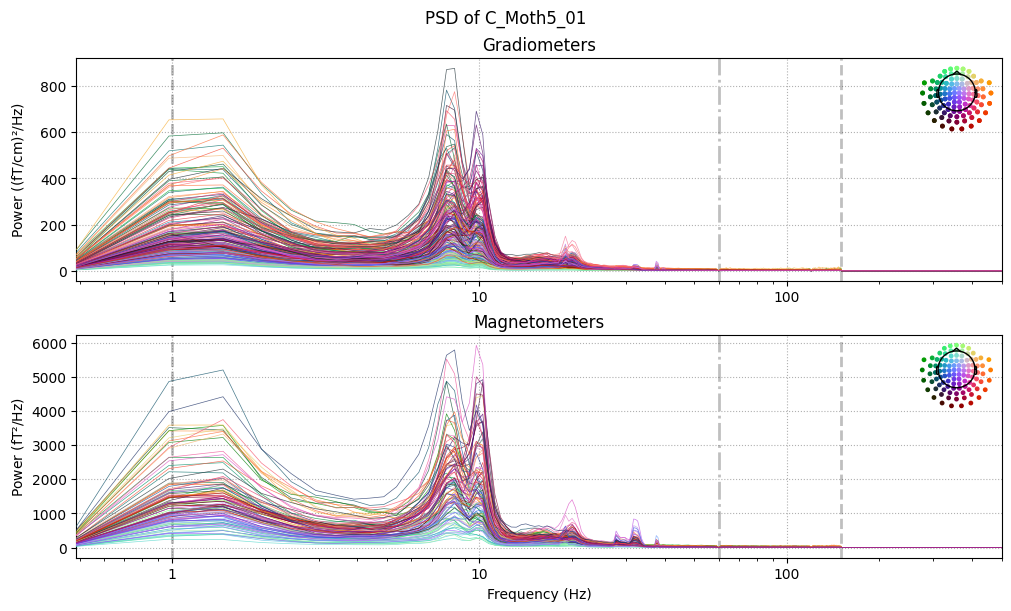

Effective window size : 2.048 (s)
Plotting power spectral density (dB=False).


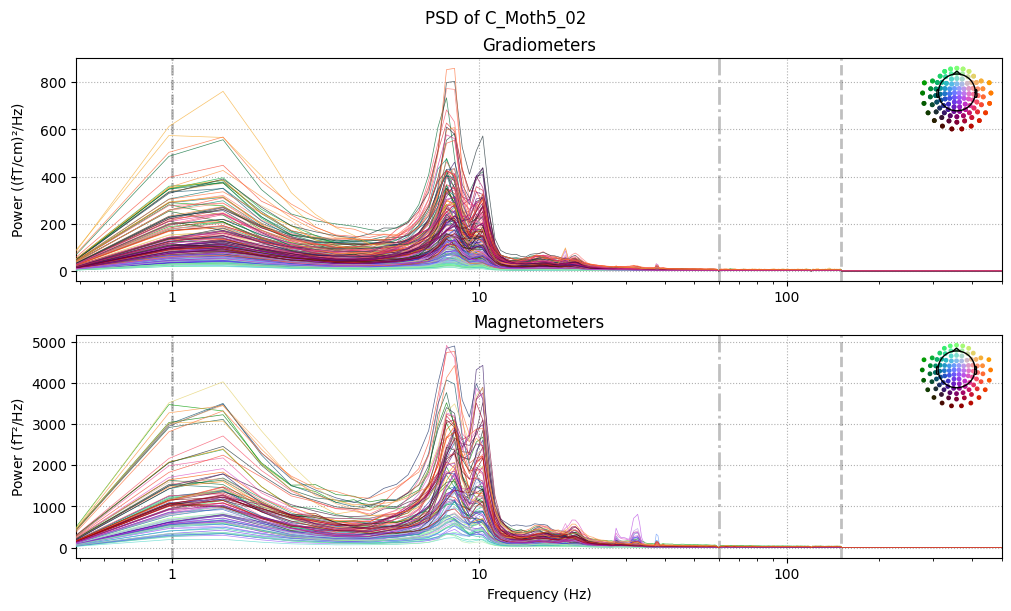

Effective window size : 2.048 (s)
Plotting power spectral density (dB=False).


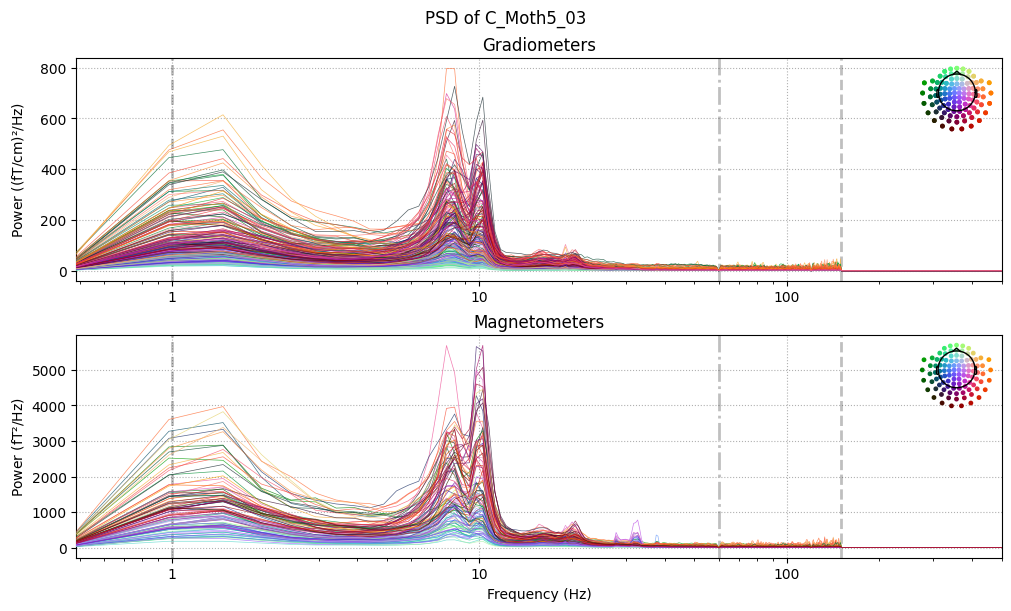

Effective window size : 2.048 (s)
Plotting power spectral density (dB=False).


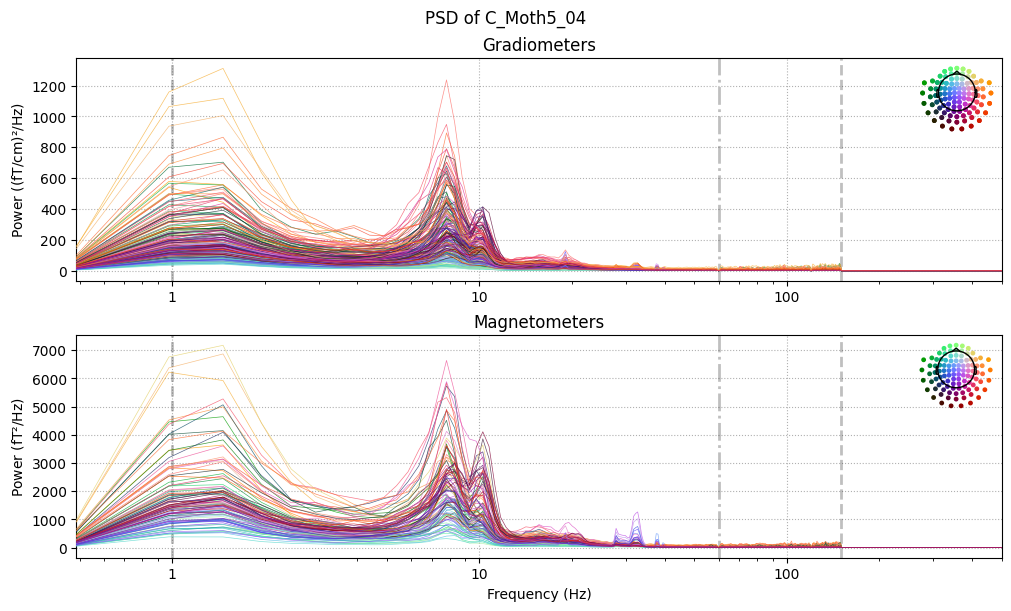

Effective window size : 2.048 (s)
Plotting power spectral density (dB=False).


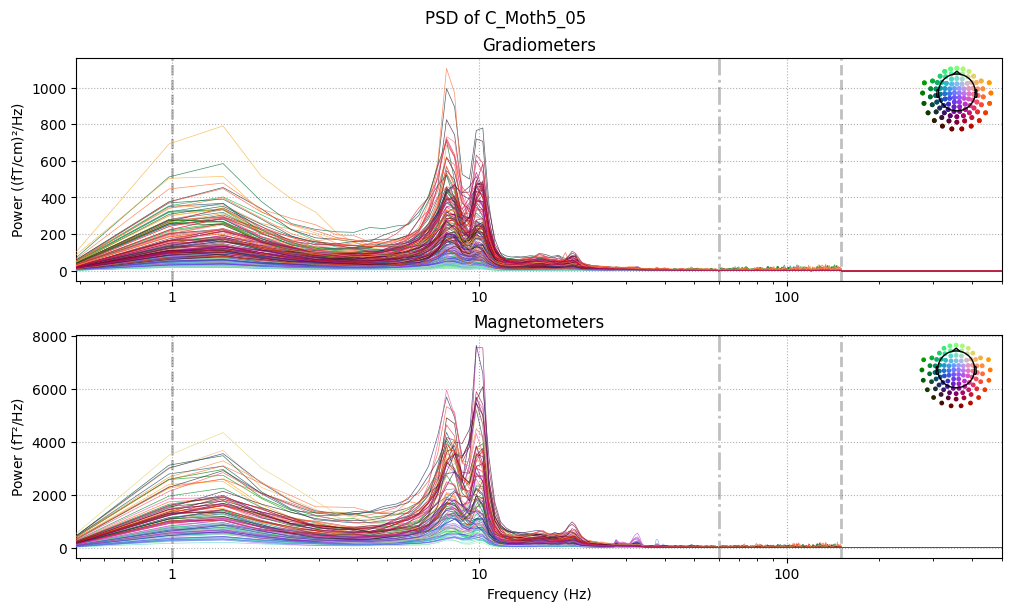

Effective window size : 2.048 (s)
Plotting power spectral density (dB=False).


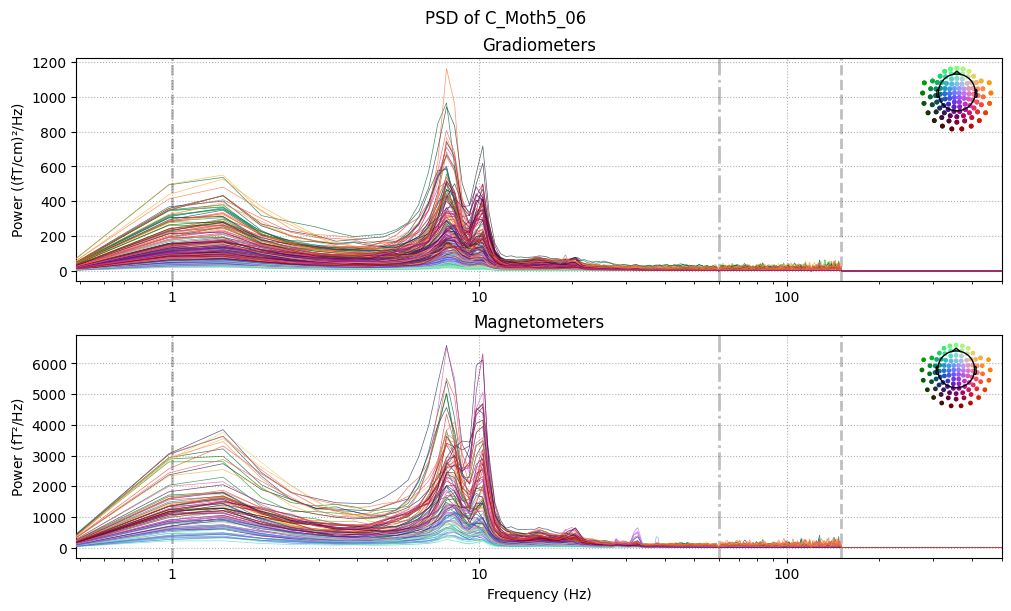

Effective window size : 2.048 (s)
Plotting power spectral density (dB=False).


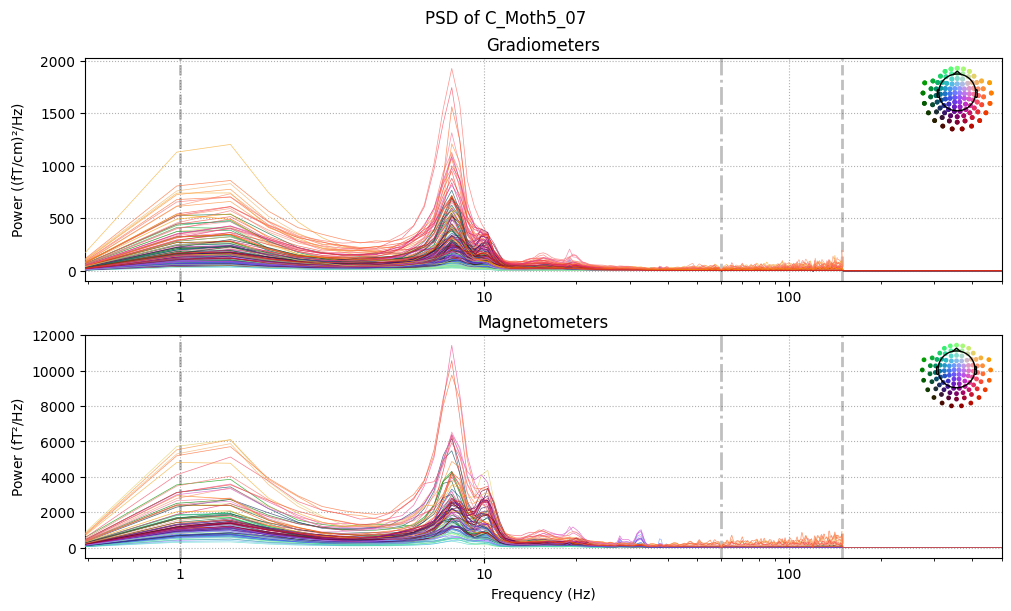

In [80]:
average = False
if PLOT:
    for raw_sss, BLOCK in zip(all_raw_sss, BLOCKS):
        spectrum = raw_sss.compute_psd()
        spectrum.plot(average=average, dB=False, xscale="log")
        plt.suptitle(f"PSD of {SUBJECT}_{SESSION}_{BLOCK}")
        plt.show()